# Midterm project submission
**Due April 5th (Friday) before class.** Counts for 1/3 of the overall project grade (10% of the final grade).

You should address all the questions relevant to your project.
You will not be graded based on the values of the model performance, but on whether or not you have applied the right methodology: formulated the business model, translated it into a right machine learning approach, analyzed your data, prepared it for modeling, applied at least two different machine learning algorithms, used cross validation for model tuning, justified your tuning metric, set up the proper machine learning pipeline without data leakage, evaluated your model using all the relevant metrics, and justified all your decisions.

If you have tried different approaches, please include them all, and not just the best one.
If doing some feature engineering or feature selection has improved your model, also please include all of the steps, not just the most successful ones.

You should submit the notebook with the code, output and explanations. The notebook should be executable and comprehensible.

The points will be deducted for the following reasons:
- data leakage
- unjustified decisions (no discussion on: choice of metric for optimization, choice of the number of components of PCA if used, or blind removal of outliers...)
- notebook not comprehensible
- notebook with incomplete output
- notebook not executable
- blind copy pasting from ChatGPT, if the copied code is not suitable for the task
- writing your own code (or copy pasting them from outside source) for simple functions that we covered and that already exist in `sklearn` (train test split, plain grid search, encoding of categorical variables,...), as this leads to:
    - convoluted code prone to bugs
    - code that is hard to understand and review
    - waste of data scientist's time if ready-made simple functions exist

Additional points will be awarded for trying and testing different relevant approaches, from exploratory data analysis, to feature engineering, to modeling and evaluation.

There should be one submission per group, but team member evaluation can be submitted per person. If not submitted, the default is that all the team members have contributed equally to the project and should get the same grade.

Here, fill out group number, student IDs, and project name.
### Group number: Group 10
### Student IDs: 47193; 47024; 46780; 47395;
### Project name: Project 10 - Airline Satisfaction

## What business problem are you solving?
- Predict customer satisfaction based on a set of variables
- *Elaborate why is this a relevant problem, and what can you do with the model output to create business value, i.e., how is the model output actionable. (2-3 paragraphs)*

## What is the machine learning problem that you are solving?
- Please state clearly what is the ML problem. Is it a **classification** problem or a regression problem? Is the goal to build a model that generates a ranked list, or is it to detect anomalies as new data come in?
    - Classification problem. The goal is to build a model that can accurately classify customer satisfaction based on flight data and customer data.
- Are you doing clustering to find hidden patterns?
- If applicable state your target. - Satisfaction

## Data exploration and preparation 

- How many data instances do you have? - 100k
- Do you have duplicates? - No
- How many features? What type are they? - 1 identifier, 22 features, 1 target; 
- If they are categorical, what categories they have, what is their frequency?
- If they are numerical, what is their distribution?
- What is the distribution of the target variable?
- If you have a target, you can also check the relationship between the target and the variables.
- Do you have missing data? If yes, how are you going to handle it?
- Can you use the features in their original form, or do you need to alter them in some way?
- What have you learned about your data? Is there anything that can help you in feature engineering or modeling?

If you have a lot of features, for midterm submission, you can choose to use only a subset. The same goes for data, if you use a reasonable subset of data for the problem at hand.

#### Data Problems
- Departure Convenience through Baggage Handling: 0 is N/A
- Negative Age and Flight Distance
- Typos (Gender and Customer Type)
- Missing Values

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette(palette = "crest")

In [4]:
miss_cols = ['Departure and Arrival Time Convenience', 'Ease of Online Booking','Check-in Service', 'Online Boarding', 'Gate Location',
        'On-board Service', 'Seat Comfort', 'Leg Room Service', 'Cleanliness', 'Food and Drink', 'In-flight Service', 'In-flight Wifi Service',
        'In-flight Entertainment', 'Baggage Handling']
miss_dict = {col: ['0'] for col in miss_cols}


df = pd.read_csv("pr10_airline_satisfaction.csv", na_values=miss_dict)
print(f"Number of instances: {df.shape[0]}")
print(f"Number of duplicated observations: {df.duplicated().sum()}")
print(f"Number of features: {len(df.columns)-2}")

Number of instances: 100000
Number of duplicated observations: 0
Number of features: 22


In [5]:
categorical_variables = df.select_dtypes(exclude="number").drop("Satisfaction", axis=1).columns
continuous_variables = pd.Index(["Age", "Flight Distance", "Departure Delay", "Arrival Delay"])
discrete_variables = df.columns.drop(continuous_variables.append(categorical_variables).append(pd.Index(["ID", "Satisfaction"])))
# Some categorical variables display typographical errors
"""
for col in categorical_variables:
    print(df[col].unique())
"""

df.head(2)

,ID,Gender,Age,Customer Type,Type of Travel,Class,Flight Distance,Departure Delay,Arrival Delay,Departure and Arrival Time Convenience,...,On-board Service,Seat Comfort,Leg Room Service,Cleanliness,Food and Drink,In-flight Service,In-flight Wifi Service,In-flight Entertainment,Baggage Handling,Satisfaction
0,15637,Female,25.0,First-time,Business,Economy Plus,229,0,0.0,NaN,...,5.0,4.0,3.0,4.0,4.0,2.0,NaN,4.0,4.0,Satisfied
1,76,Male,55.0,First-time,Business,Economy,108,0,0.0,NaN,...,5.0,5.0,2.0,4.0,4.0,2.0,5.0,4.0,5.0,Satisfied


### Initial Data Transformation

**Rever** - Talvez faça mais sentido utilizar outros métodos para lidar com missing data

In [4]:
# Negative values for Flight Distance and Age
df["Flight Distance"] = df["Flight Distance"].apply(np.abs)
df["Age"] = df["Age"].apply(np.abs)

miss = df.isnull().sum().sort_values(ascending=False).head(5)
miss

Arrival Delay             296
Online Boarding            79
Ease of Online Booking     79
Leg Room Service           79
Seat Comfort               79
dtype: int64

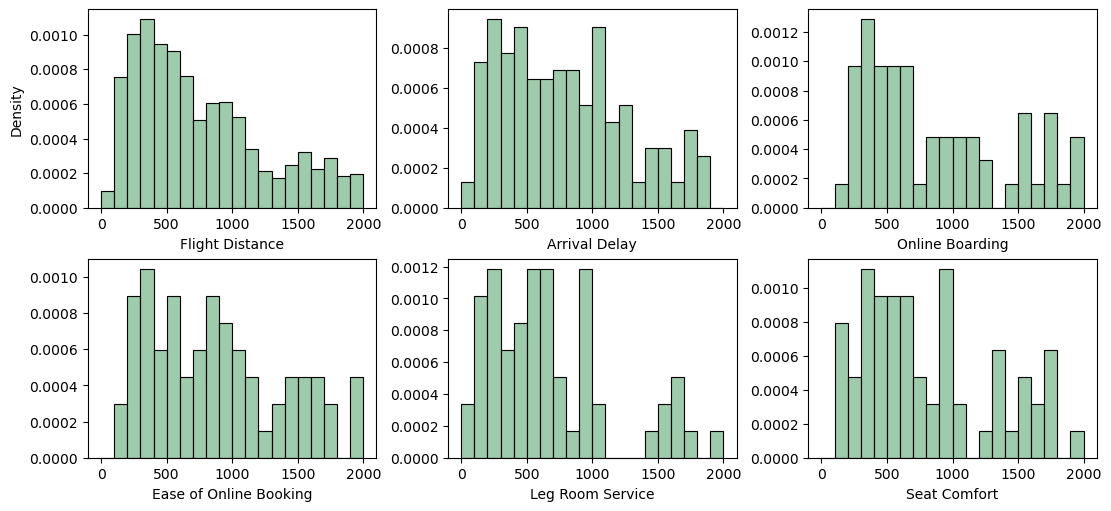

In [5]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, sharex = False, sharey = False, layout = "constrained", figsize = (11, 5))
axes = axes.ravel()
sns.histplot(data=df, x="Flight Distance", bins = np.arange(0,21)*100, ax=axes[0], stat="density", label="")
for col, ax in zip(miss.index, axes[1:]):
    miss_df = df[df[col].isna()]
    sns.histplot(data=miss_df, x="Flight Distance", bins = np.arange(0, 21)*100, ax=ax, stat="density")
    ax.set_xlabel(col)
    ax.set_ylabel("")

plt.show()    

<Axes: xlabel='Flight Distance', ylabel='Count'>

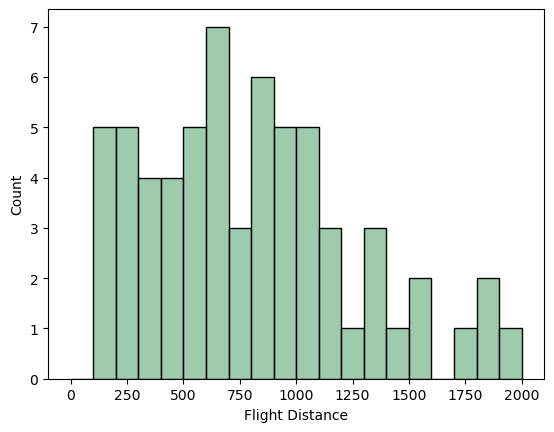

In [6]:
dep = df.copy()
dep["Null"] = df["Departure and Arrival Time Convenience"].isna()

dep_null = dep[dep["Null"]]
sns.histplot(data=dep_null, x="Flight Distance", bins = np.arange(0, 21)*100)

**Departure, Ease of Booking, Online Boarding, In-flight**

<Axes: xlabel='Departure and Arrival Time Convenience', ylabel='Flight Distance'>

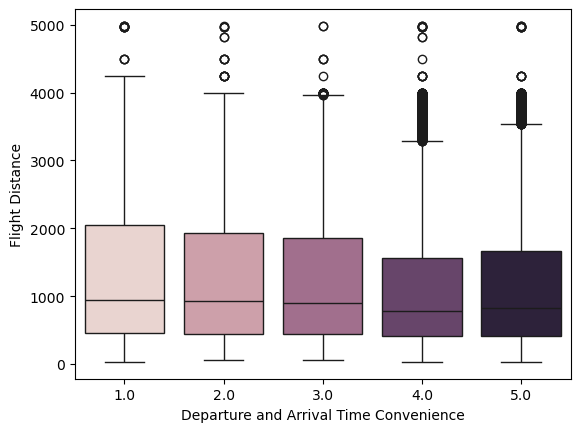

In [8]:
dep = df.copy()
dep["Null"] = df["Departure and Arrival Time Convenience"].isna()
sns.boxplot(data=dep, x="Departure and Arrival Time Convenience", y="Flight Distance", hue = "Departure and Arrival Time Convenience", legend=False)

In [9]:
initial_count = df["ID"].count() # Initial number of instances

# Replace reocurring instances for the standard ones
df["Gender"] = df["Gender"].replace(["M", "F"], ["Male", "Female"])
df["Customer Type"] = df["Customer Type"].replace(["returning", "first-time"], ["Returning", "First-time"])

# Find the valid indexes
gender = (df["Gender"] == "Male") | (df["Gender"] == "Female")
travel = (df["Type of Travel"] == "Business") | (df["Type of Travel"] == "Personal")

# Drop the unwanted rows, along with any rows containing null values
df = df[(gender & travel)]
df = df.dropna()

final_count = df["ID"].count() # Final number of instances
print(f"Dropped {initial_count - final_count} out of {initial_count} initial instances, {(1-final_count/initial_count)*100:.3f}% of total instances.\n{final_count} instances left.")

Dropped 9596 out of 100000 initial instances, 9.596% of total instances.
90404 instances left.


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 90404 entries, 2 to 99999
Data columns (total 24 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   ID                                      90404 non-null  int64  
 1   Gender                                  90404 non-null  object 
 2   Age                                     90404 non-null  float64
 3   Customer Type                           90404 non-null  object 
 4   Type of Travel                          90404 non-null  object 
 5   Class                                   90404 non-null  object 
 6   Flight Distance                         90404 non-null  int64  
 7   Departure Delay                         90404 non-null  int64  
 8   Arrival Delay                           90404 non-null  float64
 9   Departure and Arrival Time Convenience  90404 non-null  float64
 10  Ease of Online Booking                  90404 non-null  float64

### Variable Distribution

Categorical Variables

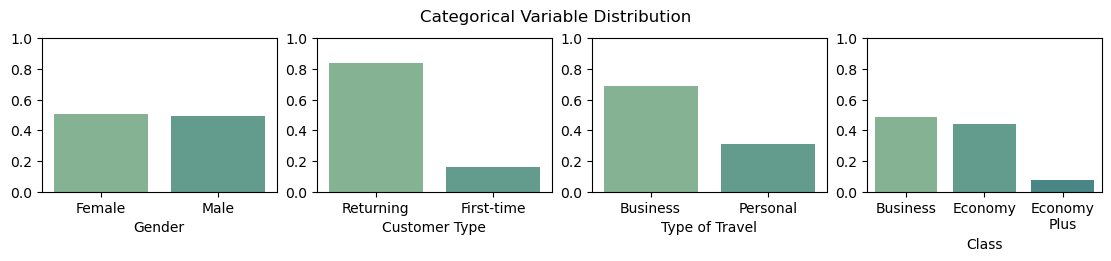

In [11]:
fig, axes = plt.subplots(nrows = 1, ncols = 4, sharex = False, sharey = False, figsize=(11, 2.5), layout="constrained")
axes = axes.ravel()

for col, ax in zip(categorical_variables, axes):
    count = pd.DataFrame(df[col].value_counts(normalize=True)).reset_index()
    sns.barplot(data = count, x = col, y = "proportion", hue = col, ax=ax, legend = False)
    ax.set_ylim([0,1])
    ax.set_ylabel("")

axes[3].set_xticks([0, 1, 2], labels=["Business", "Economy", "Economy\nPlus"])
plt.suptitle("Categorical Variable Distribution")

plt.show()

Continuous Variables

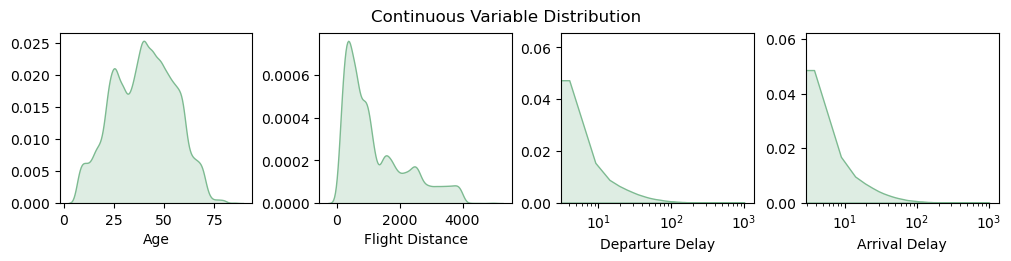

In [12]:
fig, axes = plt.subplots(nrows = 1, ncols = 4, sharex = False, sharey = False, figsize=(10,2.5), layout="constrained")
axes = axes.ravel()

for col, ax in zip(continuous_variables, axes):
    sns.kdeplot(df[col], ax=ax, fill=True)
    ax.set_ylabel("")

plt.suptitle("Continuous Variable Distribution")
axes[2].set_xscale("log")
axes[3].set_xscale("log")

plt.show()

Discrete Variables

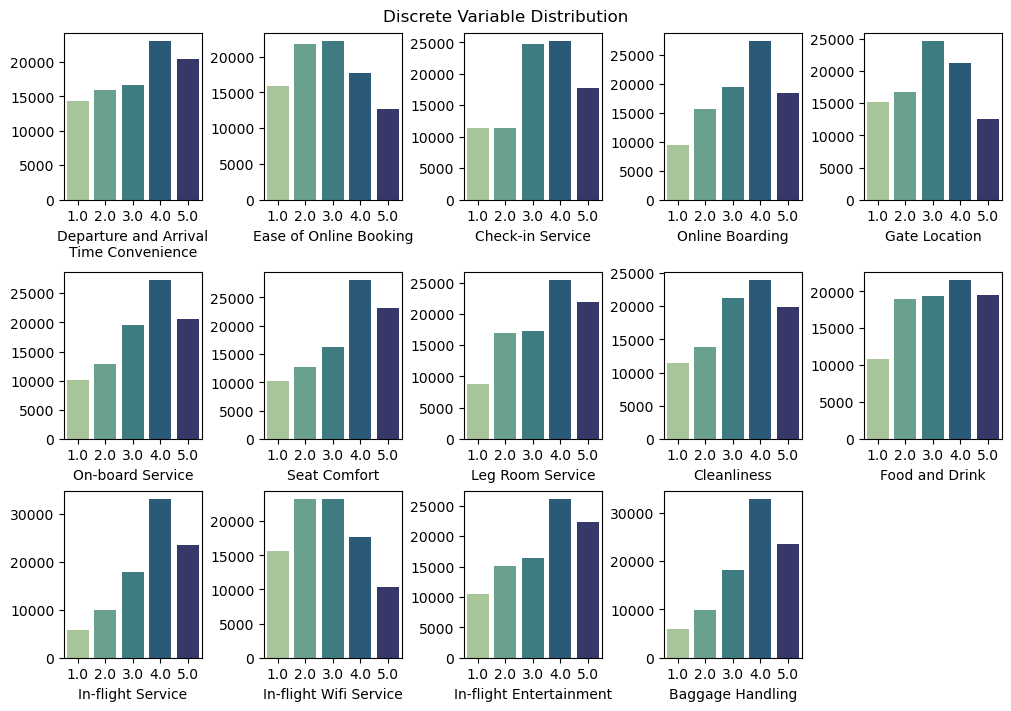

In [13]:
fig, axes = plt.subplots(nrows = 3, ncols = 5, sharex = False, sharey = False, figsize=(10, 7), layout="constrained")
axes = axes.ravel()

for col, ax in zip(discrete_variables, axes):
    data = pd.DataFrame(df[col].value_counts()).reset_index()
    sns.barplot(data = data, x = col, y = "count", ax=ax, hue=col, legend=False, palette = "crest")
    ax.set_ylabel("")

axes[0].set_xlabel("Departure and Arrival\nTime Convenience")
axes[-1].set_axis_off()
plt.suptitle("Discrete Variable Distribution")

plt.show()


### Target and Variable Relationship

Categorical Variables

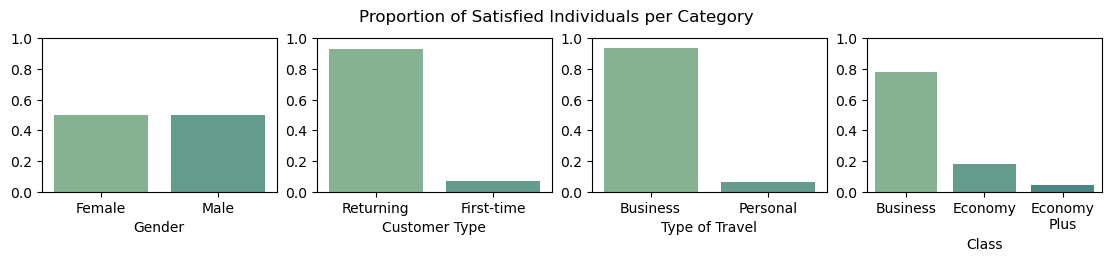

In [14]:
fig, axes = plt.subplots(nrows = 1, ncols = 4, sharex = False, sharey = False, figsize = (11,2.5), layout = "constrained")
axes = axes.ravel()

for col, ax in zip(categorical_variables, axes):
    g = pd.DataFrame(df.groupby("Satisfaction")[col].value_counts(normalize=True)["Satisfied"]).reset_index()
    sns.barplot(data = g, x = col, y = "proportion", hue = col, legend = False, ax=ax)
    ax.set_ylim([0,1])
    ax.set_ylabel("")

axes[3].set_xticks([0, 1, 2], labels=["Business", "Economy", "Economy\nPlus"])
plt.suptitle("Proportion of Satisfied Individuals per Category")

plt.show()

***Muita Informação Aqui***

Continuous Variables

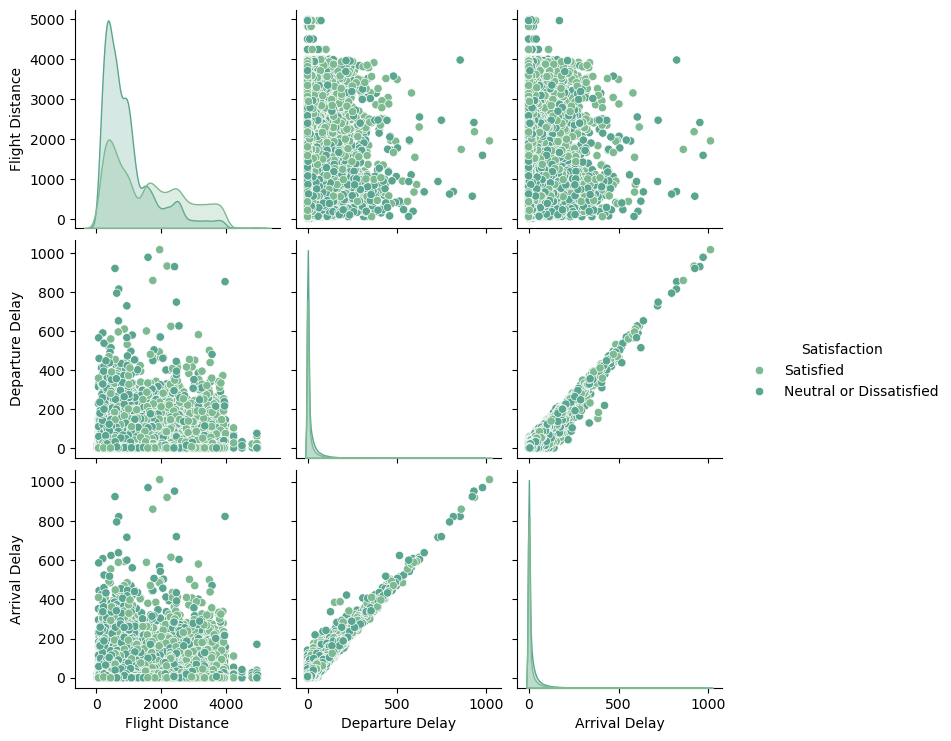

In [15]:
pair_variables = continuous_variables.append(pd.Index(["Satisfaction"])).drop("Age")
sns.pairplot(df[pair_variables], hue = "Satisfaction")

Possivelmente remover Departure Delay ou Arrival Delay?

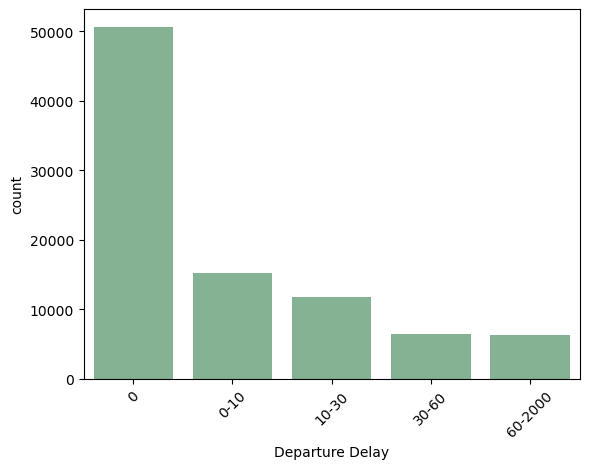

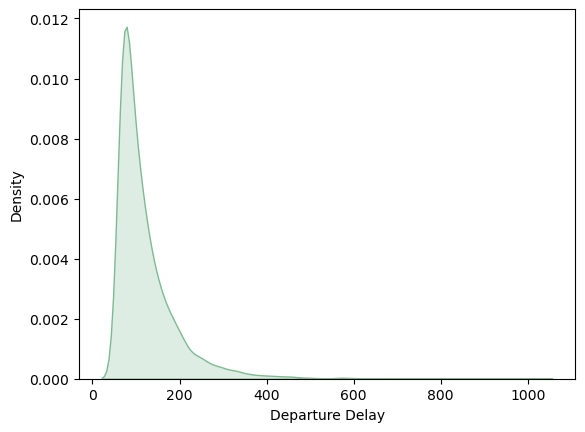

### Transformations

**One Hot Encoding**
- Gender
- Customer Type
- Travel Type

**Ordinal Encoding**
- Class

**Feature Scaling (needs to be separated into training data first)**
- Numerical Variables

## Feature engineering
Creating good features is probably the most important step in the machine learning process. 
This might involve doing:
- transformations
- aggregating over data points or over time and space, or finding differences (for example: differences between two monthly bills, time difference between two contacts with the client) 
- creating dummy (binary) variables
- discretization

Business insight is very relevant in this process.


**For the midterm submission, you should do all the pre-processing necessary for the model that you selected (for example encoding of categorical variables, scaling), and test at least one feature selection method (if the feature selection does not help, still show that you tried it out).**

For the final submission you should try different approaches for feature scaling, feature selection,...
If it is possible you can also find additional relevant data.

## Modeling
You should implemente AT LEAST TWO approaches we covered so far, and tune of at least two hyperparameters of each approach.
Do not forget that you should split your data into train and test set.
You should do model selection and tuning using cross validation on the train set, avoiding data leakage.
Explain and justify what is the metric you are using for model selection and tuning.

## Model evaluation

After selecting and tuning your model on the train set, you should evaluate its performance on the test set. 
You might have tuned your model using a certain metric, but now you should describe the model performance using all relevant metrics. 
If you have some business insight, why a certain metric is relevant, you should explain it. 
For example, in disease detection, you might not want to have a false positive rate higher than some threshold (say 5%).
Choose a suitable baseline to benchmark your result and to put them in the context.

If you preformed clustering, you should describe and visualize your clusters.

## Next steps

If you already have an idea what are the next steps for your project, please describe them.
This part is not graded, but can help us give you feedback.